In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Create a shortcut to your project directory
project_path = '/content/drive/MyDrive/MiniProject/LLM'  # Adjust this path as needed
!mkdir -p {project_path}

Mounted at /content/drive


In [2]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install shap lime
!pip install transformers torch
!pip install xgboost lightgbm
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a6f5e9c9a828fd6462207a8626b55e64bbf8f53b337fa7e59f33bbd7e245719d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Basic data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Explainable AI
import shap
import lime
import lime.lime_tabular

# For LLM integration (we'll use these later)
import transformers

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [24]:
# Create a simple synthetic dataset for testing
def create_test_dataset(n_samples=500000, anomaly_percentage=0.20):
    """
    Create a synthetic dataset for cloud user behavior analytics.

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    anomaly_percentage : float
        Percentage of samples that should be anomalies (between 0 and 1)

    Returns:
    --------
    pandas.DataFrame
        Synthetic dataset with features and labels
    """
    # User IDs
    user_ids = np.random.choice(range(1, 51), n_samples)

    # Time features
    hours = np.random.randint(0, 24, n_samples)
    weekdays = np.random.randint(0, 7, n_samples)

    # Action types
    action_types = np.random.choice(['login', 'download', 'upload', 'delete', 'admin'],
                                   n_samples,
                                   p=[0.5, 0.2, 0.2, 0.05, 0.05])

    # Resource access counts
    resource_access = np.random.poisson(5, n_samples)

    # Failed attempts
    failed_attempts = np.random.poisson(0.5, n_samples)

    # Data volume (in MB)
    data_volume = np.random.exponential(10, n_samples)

    # Location changes (binary)
    location_changes = np.random.binomial(1, 0.1, n_samples)

    # Create anomalies based on specified percentage
    is_anomaly = np.zeros(n_samples, dtype=int)
    anomaly_indices = np.random.choice(range(n_samples),
                                      size=int(anomaly_percentage * n_samples),
                                      replace=False)

    # Make anomalies have unusual patterns
    for idx in anomaly_indices:
        is_anomaly[idx] = 1
        # Anomalies have more failed attempts
        failed_attempts[idx] += np.random.randint(3, 10)
        # Anomalies often happen at unusual hours
        if np.random.random() < 0.7:
            hours[idx] = np.random.choice([0, 1, 2, 3, 4])
        # Anomalies often involve admin actions
        if np.random.random() < 0.6:
            action_types[idx] = 'admin'
        # Anomalies often have location changes
        location_changes[idx] = 1
        # Anomalies often involve large data transfers
        if action_types[idx] in ['download', 'upload']:
            data_volume[idx] *= np.random.randint(10, 50)

    # Create DataFrame
    df = pd.DataFrame({
        'user_id': user_ids,
        'hour_of_day': hours,
        'day_of_week': weekdays,
        'action_type': action_types,
        'resource_access_count': resource_access,
        'failed_attempts': failed_attempts,
        'data_volume_mb': data_volume,
        'location_change': location_changes,
        'is_anomaly': is_anomaly
    })

    return df

# Generate test dataset
test_df = create_test_dataset()

# Display the first few rows
print("Dataset shape:", test_df.shape)
test_df.head()

Dataset shape: (500000, 9)


,user_id,hour_of_day,day_of_week,action_type,resource_access_count,failed_attempts,data_volume_mb,location_change,is_anomaly
0,36,15,4,login,7,1,9.144020,0,0
1,22,9,5,login,3,0,3.560847,0,0
2,6,9,4,login,12,0,4.441670,0,0
3,39,0,1,admin,2,4,14.871897,1,1
4,42,0,2,download,4,2,10.224541,0,0


In [25]:
# Create directories if they don't exist
!mkdir -p {project_path}/data/raw
!mkdir -p {project_path}/data/processed

# Save the test dataset
test_df.to_csv(f"{project_path}/data/raw/synthetic_cloud_logs.csv", index=False)
print(f"Dataset saved to {project_path}/data/raw/synthetic_cloud_logs.csv")

Dataset saved to /content/drive/MyDrive/MiniProject/LLM/data/raw/synthetic_cloud_logs.csv


Loaded dataset shape: (500000, 9)

Basic statistics:
Number of users: 50
Number of anomalies: 100000 (20.00%)


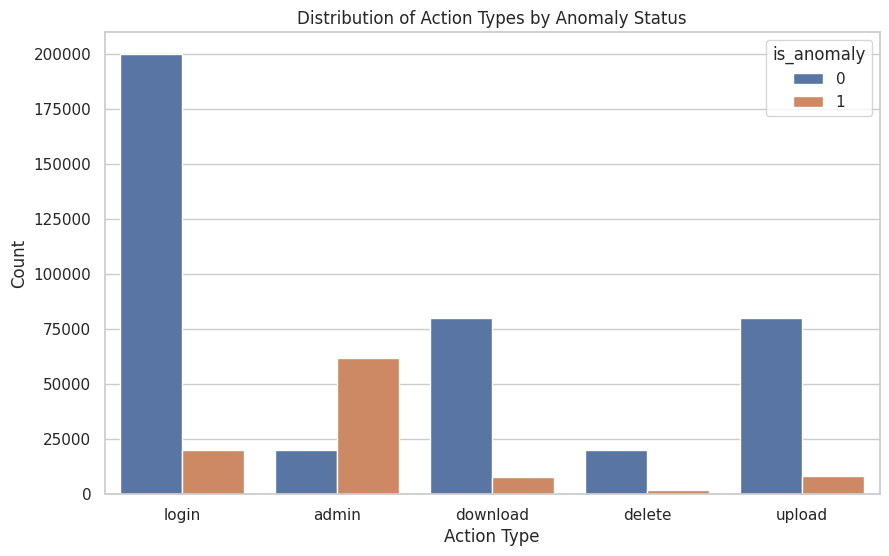

In [26]:
# Check if we can load the dataset
loaded_df = pd.read_csv(f"{project_path}/data/raw/synthetic_cloud_logs.csv")
print("Loaded dataset shape:", loaded_df.shape)

# Check basic statistics
print("\nBasic statistics:")
print(f"Number of users: {loaded_df['user_id'].nunique()}")
print(f"Number of anomalies: {loaded_df['is_anomaly'].sum()} ({loaded_df['is_anomaly'].mean()*100:.2f}%)")

# Plot distribution of actions
plt.figure(figsize=(10, 6))
sns.countplot(x='action_type', hue='is_anomaly', data=loaded_df)
plt.title('Distribution of Action Types by Anomaly Status')
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.show()

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive if working in Colab
drive.mount('/content/drive')

# Set path to your project directory
project_path = '/content/drive/MyDrive/MiniProject/LLM'

# Load the dataset
df = pd.read_csv(f"{project_path}/data/raw/synthetic_cloud_logs.csv")

# Display basic information
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display class distribution
print("\nClass distribution:")
print(df['is_anomaly'].value_counts())
print(f"Anomaly percentage: {df['is_anomaly'].mean()*100:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (500000, 9)

Data types:
user_id                    int64
hour_of_day                int64
day_of_week                int64
action_type               object
resource_access_count      int64
failed_attempts            int64
data_volume_mb           float64
location_change            int64
is_anomaly                 int64
dtype: object

Basic statistics:
            user_id    hour_of_day    day_of_week  resource_access_count  \
count  500000.00000  500000.000000  500000.000000          500000.000000   
mean       25.51998      10.152418       3.004584               5.001314   
std        14.43492       7.234197       2.001165               2.240780   
min         1.00000       0.000000       0.000000               0.000000   
25%        13.00000       3.000000       1.000000               3.000000   
50%        26.00000      10.000000       3.00

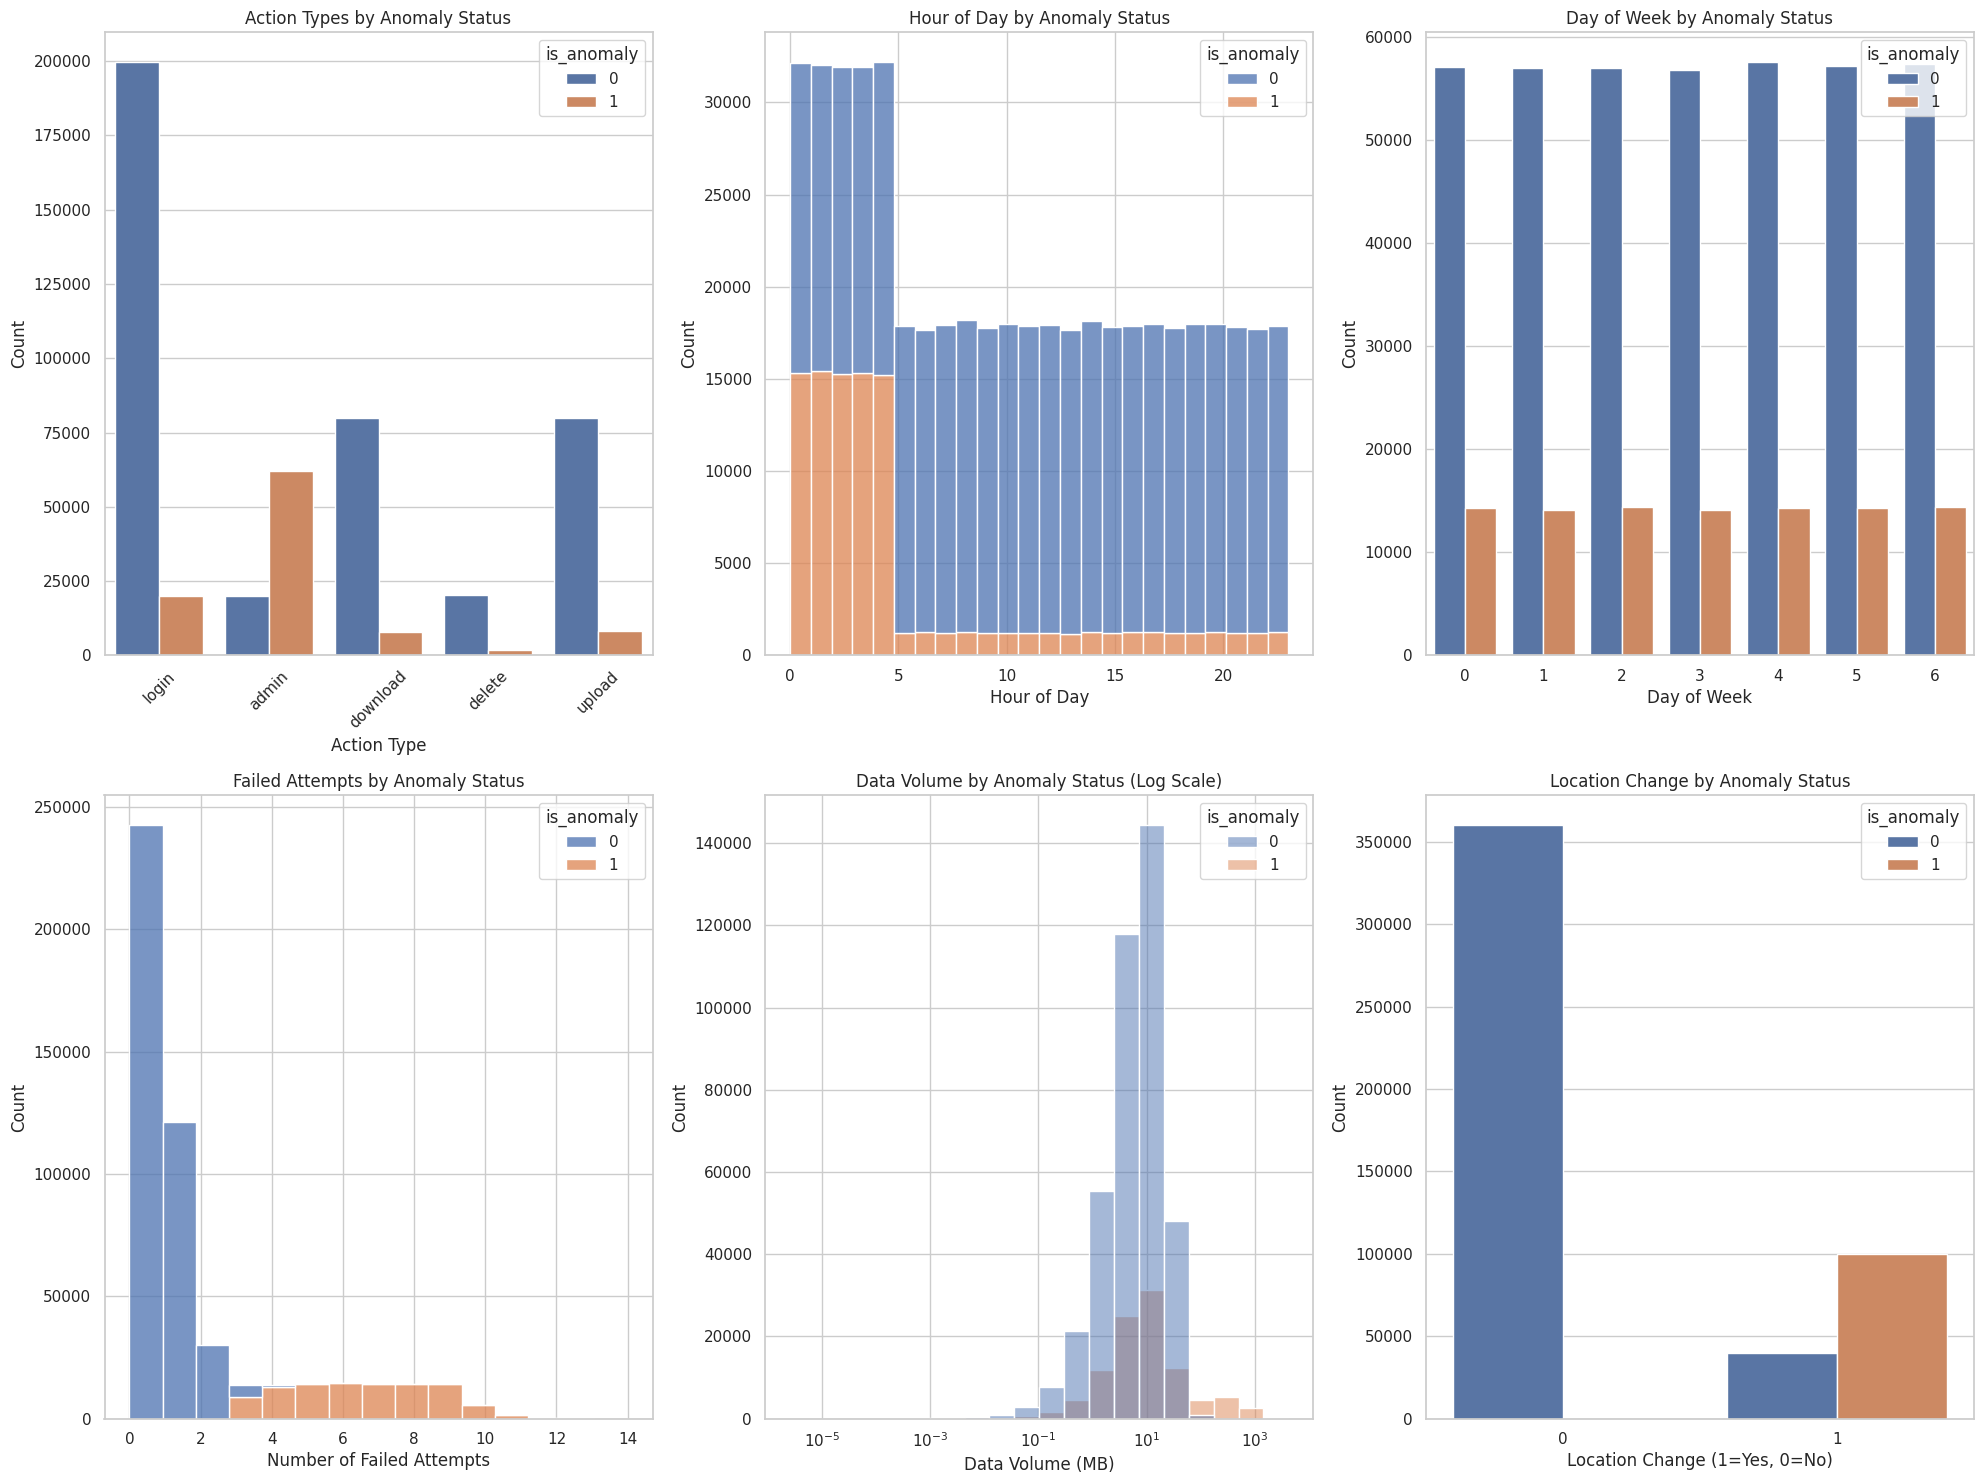

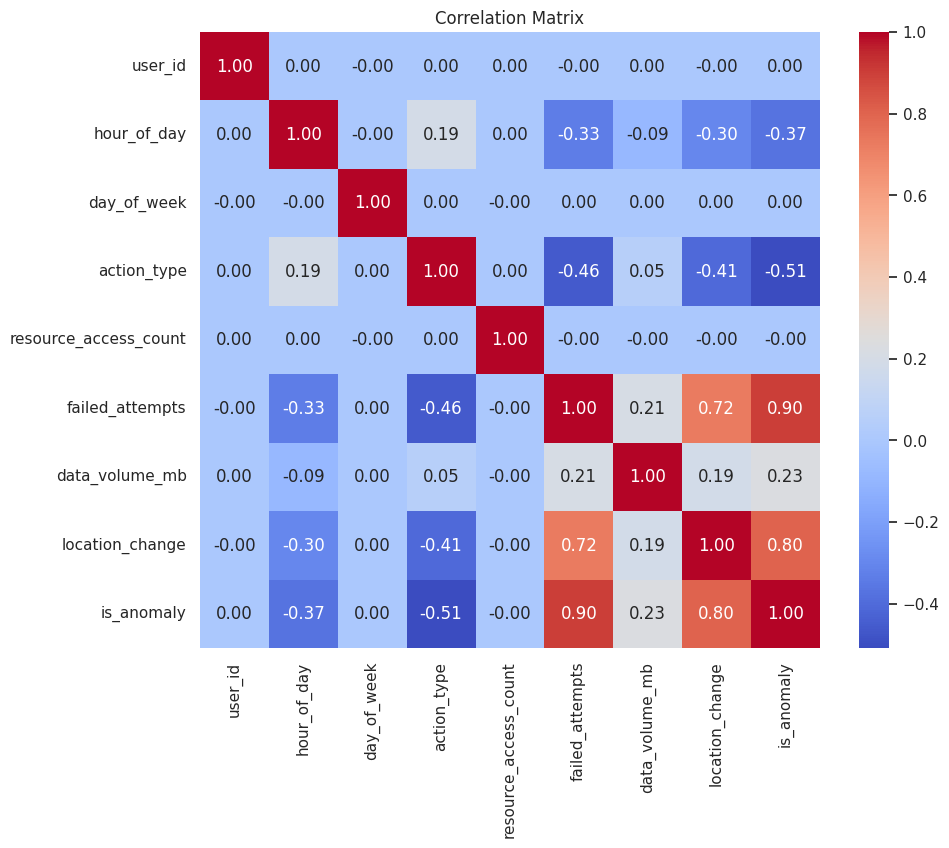

In [28]:
# Set up the visualization style
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Create a figure for multiple plots
plt.figure(figsize=(20, 15))

# 1. Distribution of action types by anomaly status
plt.subplot(2, 3, 1)
sns.countplot(x='action_type', hue='is_anomaly', data=df)
plt.title('Action Types by Anomaly Status')
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 2. Hour of day distribution by anomaly status
plt.subplot(2, 3, 2)
sns.histplot(data=df, x='hour_of_day', hue='is_anomaly', bins=24, multiple='stack')
plt.title('Hour of Day by Anomaly Status')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

# 3. Day of week distribution by anomaly status
plt.subplot(2, 3, 3)
sns.countplot(x='day_of_week', hue='is_anomaly', data=df)
plt.title('Day of Week by Anomaly Status')
plt.xlabel('Day of Week')
plt.ylabel('Count')

# 4. Failed attempts distribution
plt.subplot(2, 3, 4)
sns.histplot(data=df, x='failed_attempts', hue='is_anomaly', bins=15, multiple='stack')
plt.title('Failed Attempts by Anomaly Status')
plt.xlabel('Number of Failed Attempts')
plt.ylabel('Count')

# 5. Data volume distribution (log scale)
plt.subplot(2, 3, 5)
sns.histplot(data=df, x='data_volume_mb', hue='is_anomaly', bins=20, log_scale=True)
plt.title('Data Volume by Anomaly Status (Log Scale)')
plt.xlabel('Data Volume (MB)')
plt.ylabel('Count')

# 6. Location change by anomaly status
plt.subplot(2, 3, 6)
sns.countplot(x='location_change', hue='is_anomaly', data=df)
plt.title('Location Change by Anomaly Status')
plt.xlabel('Location Change (1=Yes, 0=No)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
# Convert categorical variables to numeric for correlation
df_corr = df.copy()
df_corr['action_type'] = df_corr['action_type'].astype('category').cat.codes
corr = df_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [29]:
# Create a copy of the dataframe for feature engineering
df_features = df.copy()

# 1. Create time-based features
# Convert hour to categorical: morning, afternoon, evening, night
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df_features['time_of_day'] = df_features['hour_of_day'].apply(categorize_hour)

# Convert day of week to weekday/weekend
df_features['is_weekend'] = df_features['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 2. Create interaction features
# Interaction between failed attempts and admin actions
df_features['failed_admin_attempts'] = ((df_features['action_type'] == 'admin') &
                                       (df_features['failed_attempts'] > 0)).astype(int)

# Interaction between night time and data volume
df_features['night_data_transfer'] = ((df_features['time_of_day'] == 'night') &
                                     (df_features['data_volume_mb'] > df_features['data_volume_mb'].median())).astype(int)

# 3. Create user behavior features
# Group by user_id and calculate statistics
user_stats = df_features.groupby('user_id').agg({
    'resource_access_count': ['mean', 'std'],
    'failed_attempts': ['mean', 'sum'],
    'data_volume_mb': ['mean', 'max'],
    'location_change': 'mean'
}).reset_index()

# Flatten the multi-level column names
user_stats.columns = ['_'.join(col).strip('_') for col in user_stats.columns.values]

# Merge user statistics back to the main dataframe
df_features = pd.merge(df_features, user_stats, on='user_id', how='left')

# 4. Calculate z-scores for numerical features to detect outliers
for col in ['resource_access_count', 'failed_attempts', 'data_volume_mb']:
    df_features[f'{col}_zscore'] = (df_features[col] - df_features[col].mean()) / df_features[col].std()

# Display the new features
print("New features added:")
print(df_features.columns.tolist())
print("\nSample of the enhanced dataset:")
print(df_features.head())

New features added:
['user_id', 'hour_of_day', 'day_of_week', 'action_type', 'resource_access_count', 'failed_attempts', 'data_volume_mb', 'location_change', 'is_anomaly', 'time_of_day', 'is_weekend', 'failed_admin_attempts', 'night_data_transfer', 'resource_access_count_mean', 'resource_access_count_std', 'failed_attempts_mean', 'failed_attempts_sum', 'data_volume_mb_mean', 'data_volume_mb_max', 'location_change_mean', 'resource_access_count_zscore', 'failed_attempts_zscore', 'data_volume_mb_zscore']

Sample of the enhanced dataset:
   user_id  hour_of_day  day_of_week action_type  resource_access_count  \
0       36           15            4       login                      7   
1       22            9            5       login                      3   
2        6            9            4       login                     12   
3       39            0            1       admin                      2   
4       42            0            2    download                      4   

   failed

In [32]:
# Import preprocessing libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Identify categorical and numerical columns
categorical_cols = ['action_type', 'time_of_day']
numerical_cols = ['hour_of_day', 'day_of_week', 'resource_access_count', 'failed_attempts',
                 'data_volume_mb', 'location_change', 'is_weekend',
                 'resource_access_count_mean', 'resource_access_count_std',
                 'failed_attempts_mean', 'failed_attempts_sum',
                 'data_volume_mb_mean', 'data_volume_mb_max',
                 'location_change_mean',
                 'resource_access_count_zscore', 'failed_attempts_zscore', 'data_volume_mb_zscore']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split the data into features and target
X = df_features.drop(['is_anomaly', 'user_id', 'failed_admin_attempts', 'night_data_transfer'], axis=1)
y = df_features['is_anomaly']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

print(f"Training set shape: {X_train_processed.shape}")
print(f"Testing set shape: {X_test_processed.shape}")
print(f"Number of features after preprocessing: {X_train_processed.shape[1]}")

# Save the preprocessed data and preprocessor
import joblib
joblib.dump(preprocessor, f"{project_path}/models/preprocessor.pkl")
np.save(f"{project_path}/data/processed/X_train.npy", X_train_processed)
np.save(f"{project_path}/data/processed/X_test.npy", X_test_processed)
np.save(f"{project_path}/data/processed/y_train.npy", y_train)
np.save(f"{project_path}/data/processed/y_test.npy", y_test)
joblib.dump(feature_names, f"{project_path}/data/processed/feature_names.pkl")

print("Preprocessed data and preprocessor saved successfully!")

Training set shape: (400000, 26)
Testing set shape: (100000, 26)
Number of features after preprocessing: 26
Preprocessed data and preprocessor saved successfully!


Class distribution in training set:
is_anomaly
0    320000
1     80000
Name: count, dtype: int64
Anomaly percentage in training: 20.00%

Class distribution in test set:
is_anomaly
0    80000
1    20000
Name: count, dtype: int64
Anomaly percentage in test: 20.00%


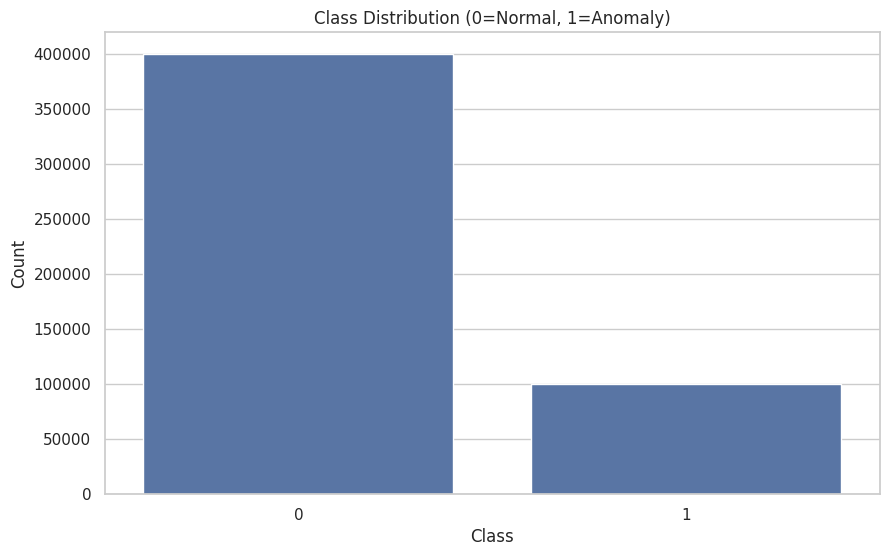


Options for handling class imbalance:
1. Use class_weight='balanced' in Random Forest
2. Apply SMOTE (Synthetic Minority Over-sampling Technique)
3. Use anomaly detection techniques instead of classification
4. Evaluate using appropriate metrics (precision, recall, F1-score, AUC)


In [33]:
# Check class distribution
print("Class distribution in training set:")
print(y_train.value_counts())
print(f"Anomaly percentage in training: {y_train.mean()*100:.2f}%")

print("\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Anomaly percentage in test: {y_test.mean()*100:.2f}%")

# Visualize class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Class Distribution (0=Normal, 1=Anomaly)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Discuss handling class imbalance
print("\nOptions for handling class imbalance:")
print("1. Use class_weight='balanced' in Random Forest")
print("2. Apply SMOTE (Synthetic Minority Over-sampling Technique)")
print("3. Use anomaly detection techniques instead of classification")
print("4. Evaluate using appropriate metrics (precision, recall, F1-score, AUC)")

In [34]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Or using random oversampling
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_processed, y_train)

print(f"Original class distribution: {pd.Series(y_train).value_counts()}")
print(f"Balanced class distribution: {pd.Series(y_train_balanced).value_counts()}")

Original class distribution: is_anomaly
0    320000
1     80000
Name: count, dtype: int64
Balanced class distribution: is_anomaly
0    320000
1    320000
Name: count, dtype: int64


In [36]:
from imblearn.under_sampling import RandomUnderSampler

# Using random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_processed, y_train)

print(f"Original class distribution: {pd.Series(y_train).value_counts()}")
print(f"Balanced class distribution: {pd.Series(y_train_balanced).value_counts()}")

Original class distribution: is_anomaly
0    320000
1     80000
Name: count, dtype: int64
Balanced class distribution: is_anomaly
0    80000
1    80000
Name: count, dtype: int64


In [38]:
from sklearn.ensemble import RandomForestClassifier

# Using 'balanced' class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

# Or specifying weights manually
# Higher weight for the minority class (anomalies)
class_weights = {0: 1, 1: 10}  # Adjust these values based on your imbalance ratio
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,
    random_state=42
)

rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)

In [39]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Using Balanced Random Forest
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42
)

brf.fit(X_train_processed, y_train)

BalancedRandomForestClassifier(random_state=42)

In [40]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Set to expected anomaly percentage
    random_state=42
)

# Train only on normal data
X_train_normal = X_train_processed[y_train == 0]
iso_forest.fit(X_train_normal)

# Predict and convert to binary labels (1 for normal, -1 for anomalies)
y_pred = iso_forest.predict(X_test_processed)
# Convert to match our labels (0 for normal, 1 for anomalies)
y_pred = np.where(y_pred == 1, 0, 1)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score

# Predict probabilities
y_pred_proba = rf_model.predict_proba(X_test_processed)[:, 1]
y_pred = rf_model.predict(X_test_processed)

# Classification report (precision, recall, F1-score)
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# ROC AUC score
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

# Average precision score (area under precision-recall curve)
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80000
           1       1.00      1.00      1.00     20000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

[[79925    75]
 [   28 19972]]
ROC AUC: 0.999940646875
Average Precision: 0.9995621648073512


Training Random Forest with balanced class weights...

Results with balanced class weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80000
           1       1.00      1.00      1.00     20000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

ROC AUC: 0.99993336875

Training Random Forest with SMOTE oversampling...

Results with SMOTE oversampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80000
           1       1.00      1.00      1.00     20000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

ROC AUC: 0.9999113103125


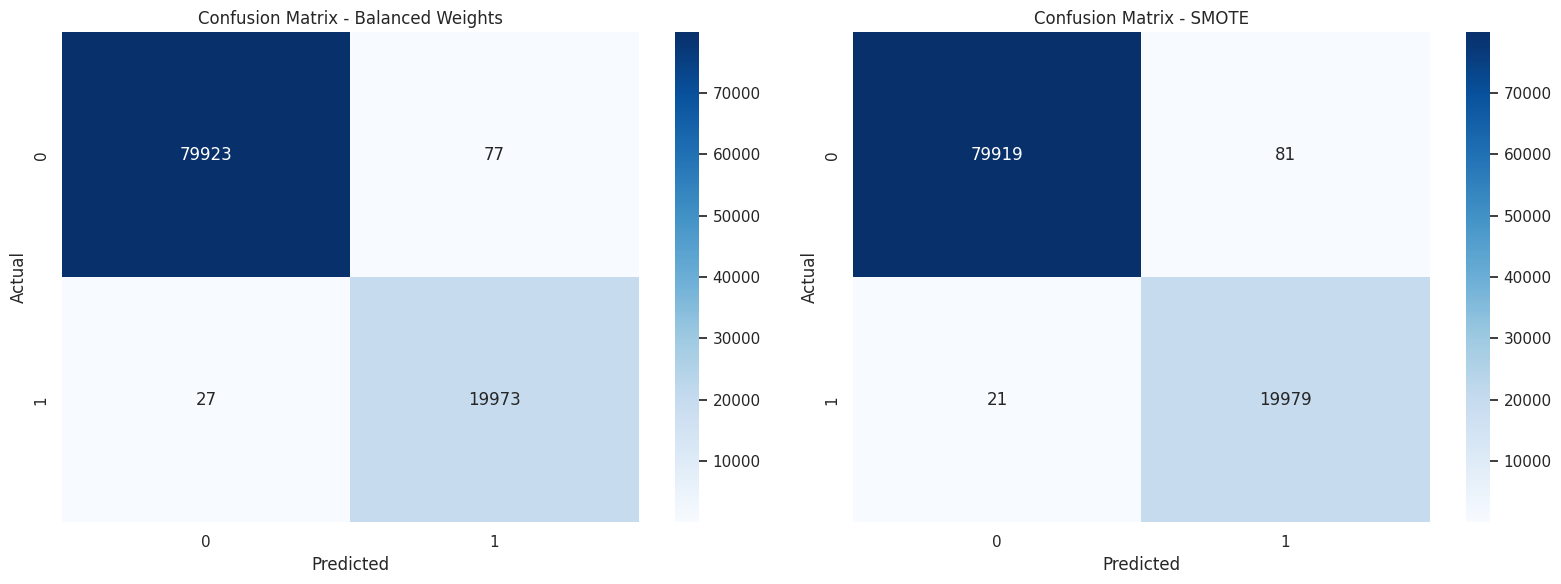

In [43]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
X_train_processed = np.load(f"{project_path}/data/processed/X_train.npy")
X_test_processed = np.load(f"{project_path}/data/processed/X_test.npy")
y_train = np.load(f"{project_path}/data/processed/y_train.npy")
y_test = np.load(f"{project_path}/data/processed/y_test.npy")

# 1. Approach: Class weights
print("Training Random Forest with balanced class weights...")
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_balanced.fit(X_train_processed, y_train)
y_pred_balanced = rf_balanced.predict(X_test_processed)
y_pred_proba_balanced = rf_balanced.predict_proba(X_test_processed)[:, 1]

print("\nResults with balanced class weights:")
print(classification_report(y_test, y_pred_balanced))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_balanced)}")

# 2. Approach: SMOTE
print("\nTraining Random Forest with SMOTE oversampling...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

rf_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test_processed)
y_pred_proba_smote = rf_smote.predict_proba(X_test_processed)[:, 1]

print("\nResults with SMOTE oversampling:")
print(classification_report(y_test, y_pred_smote))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_smote)}")

# Compare confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix for balanced weights
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix - Balanced Weights')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Confusion matrix for SMOTE
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix - SMOTE')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()